### Object detection as classification – Sliding window

Object detection is a different problem to localization as we can have a variable number of objects in the image. Consequently it becomes very tricky to handle variable number of outputs if we consider detection as just a simple regression problem like we did for localization. Therefore we consider detection as a classification problem instead.

One very common approach that has been in use for a long time is to do object detection using sliding windows. The idea is to slide a window of fixed size across the input image. What is inside the window at each location is then sent to a classifier that will tell us if the window contains an object of interest or not.

For this purpose, one can first train a CNN classifier with small closely cropped images - resized to the same size as the window - of objects we want to detect e.g. cars. At test time our fixed size window is moved in a sliding fashion across the whole image that we want to detect objects in. Our CNN then predicts for each window if it is an object (a car in this case) or not.

With only one size of sliding window we can only detect one size of object. So, to find larger or smaller objects we can also use larger and smaller windows at test time and resize the contents before sending it to the classifier. Alternatively you can resize the whole input image and use only one size sliding window that will also run across these resized images. Both methods will work but the idea is to produce what is called a ‘pyramid of scales’ so we can detect different size objects in an image.

The big downfall of this method is there can be huge number of windows from various scales passing through the CNN for prediction. This makes it very computationally expensive to use with CNNs as the classifier. Also for the most of these windows they will contain no objects anyway.

Many improvements have been made to overcome this problem. In the following sections we will go through various techniques and algorithms that have been created to tackle the problem and how newer ones have improved on what came before them.

#### R-CNN

In order to avoid running a classifier at every possible position on the input image (when most won't contain an object), we can use some external method to propose likely regions to us. One method that can do this is called Selective Search.

The region-proposal method will provide blob-like rectangular regions in the image, which are likely to contain objects of interest. These regions are the candidate areas for the presence of an object of interest. A CNN classifier is then applied only on these proposed regions. This cuts down massively on the number of crops sent to the CNN for classification, as compared to the sliding window approach.

This particular approach was suggested in 2013 and was known as R-CNN: Regions with CNN. The following diagram depicts the process of R-CNN:

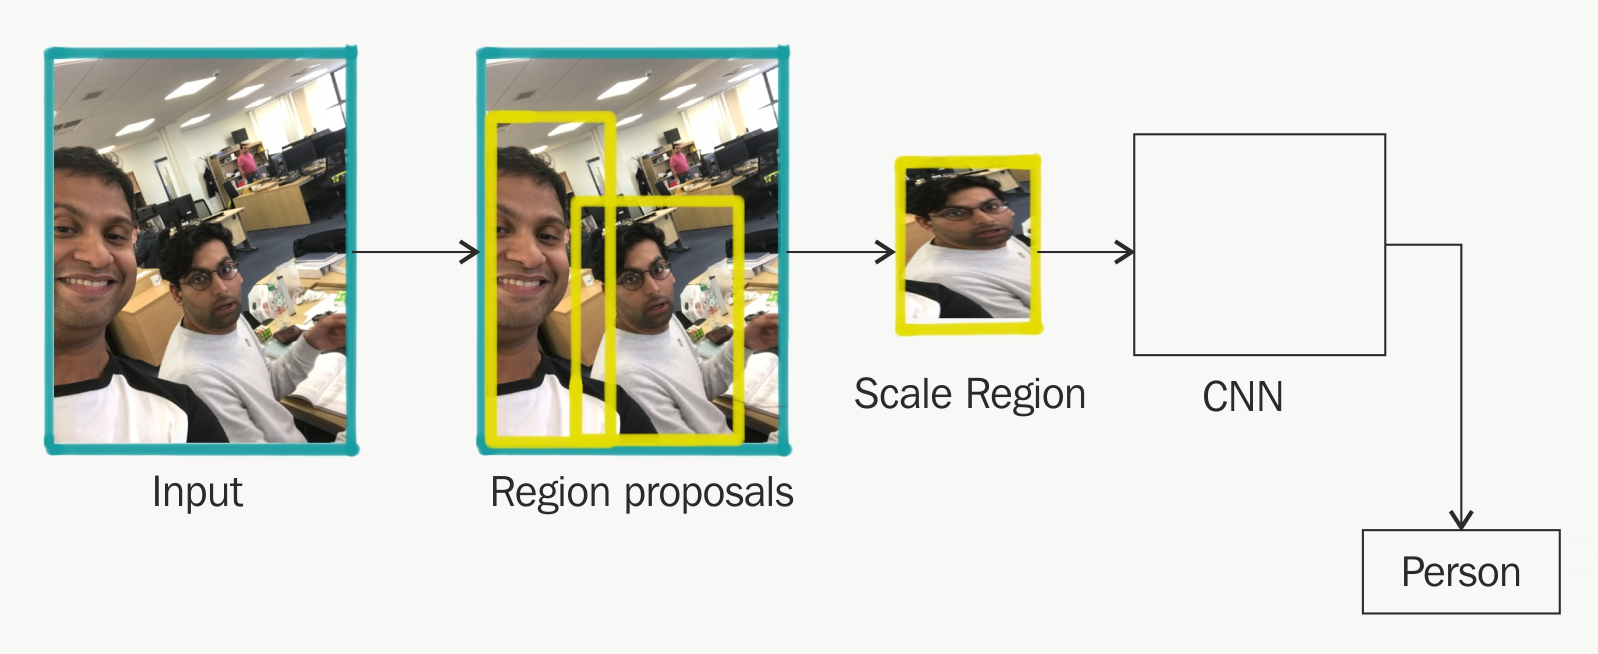

In [3]:
from IPython.display import Image
Image(filename='./images/rcnn.png',height=400,width=400)

#### Problems
R-CNN is still computationally expensive, as you have to run a CNN on around 2,000 individual region proposals. As a result, it is very slow for both training and testing. The CNN classifier relies on the fixed number of rectangular candidate windows produced by selective search for detection. This method is not the fastest around and as proposal regions are not learned from the training data, they are probably not optimal for the task.

#### Fast R-CNN

In 2015, Fast R-CNN was proposed to remedy the speed problems of R-CNN. In this method, the main change is where we get proposal regions in the pipeline. Instead of getting them directly from the input image, we first run the entire input image through a CNN and extract the generated feature map close to the end of the network. Next, again using a region-proposal method, candidate regions are extracted from this feature map in a similar manner to R-CNN.

Getting proposals in this way helps reuse and share expensive convolutional computations. The fully connected layers further down in the network that will classify, and additionally localize, only accept fixed-size input. For this reason, the proposed regions from the feature map are warped to a fixed size using a new layer called RoI pooling (discussed further in the next section). RoI Pooling resizes the regions into the size needed by the last FC layers. The whole process is shown in the following diagram:

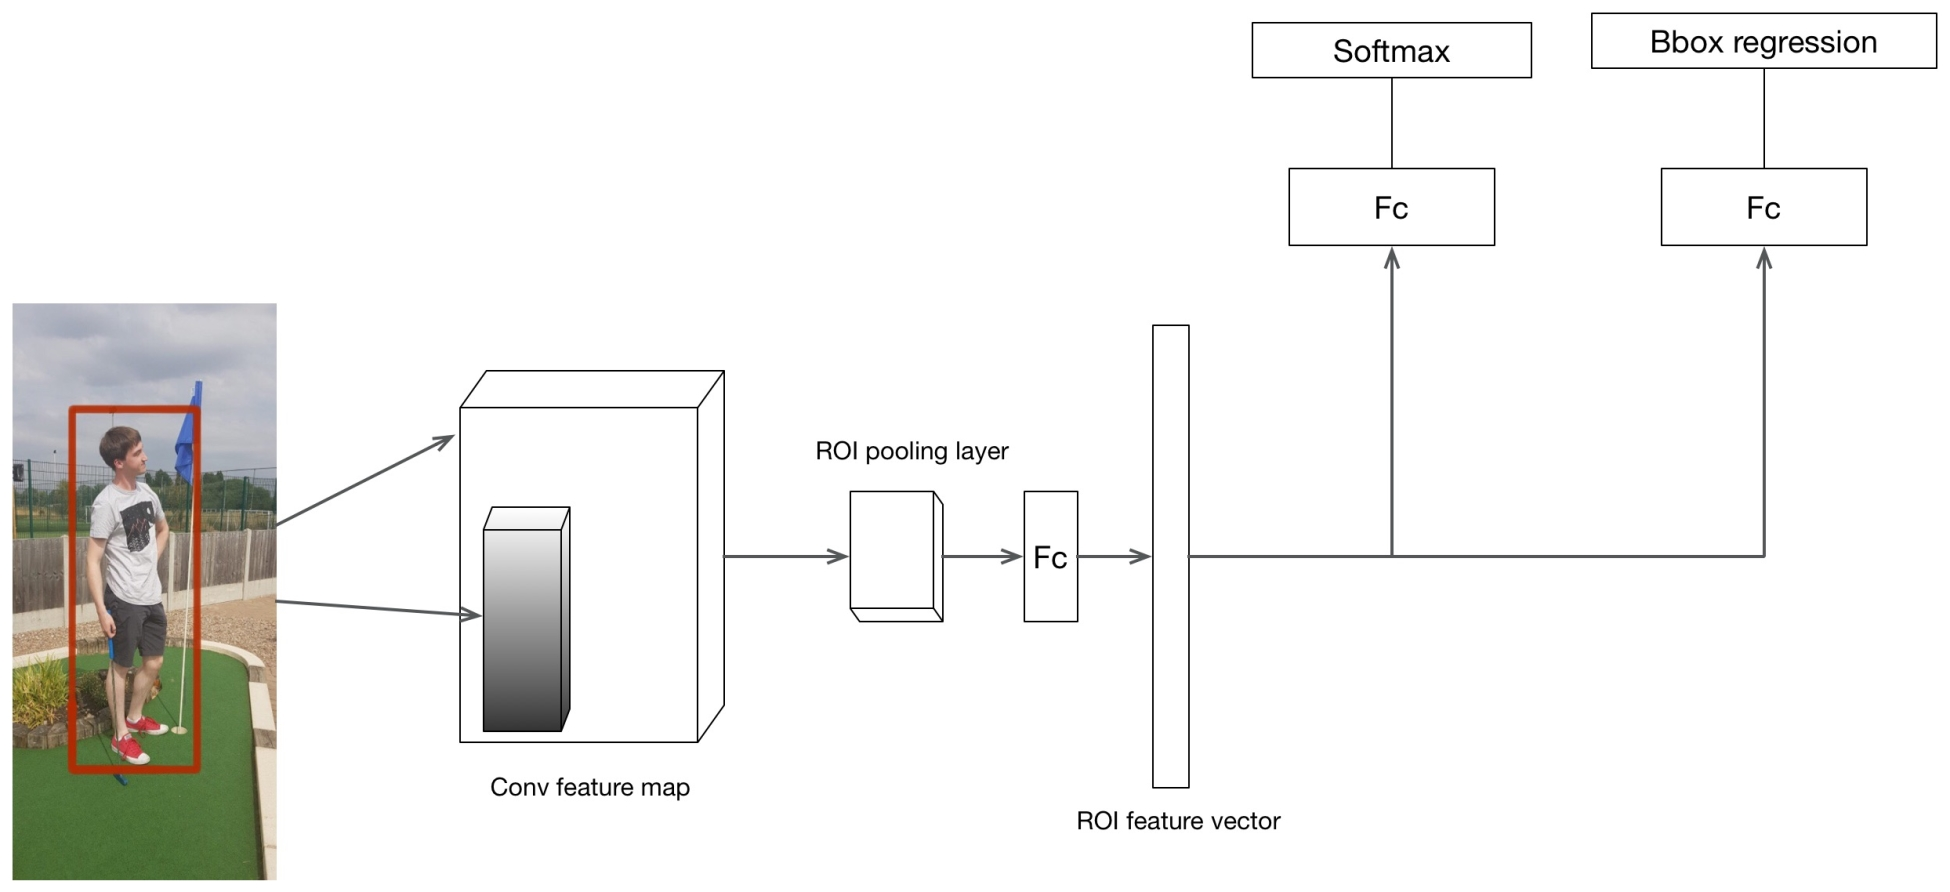

In [5]:
from IPython.display import Image
Image(filename='./images/fastrcnn.jpg',height=400,width=400)

The comparison of R-CNN and FastRCNN shows that the latter is about 10 times faster at training time and nearly 150 times faster at test time (when using a VGG architecture as the main CNN).

### Faster R-CNN
This technique, proposed shortly after Fast R-CNN in 2015, solves the need to use external region-proposal methods and removes the computational costs associated with them.

The main difference of this algorithm is that instead of using an external algorithm (such as selective search) for creating the proposals, a subnetwork called a Region Proposal network (RPN) is used to learn and generate proposals for us. This is shown in this screenshot:

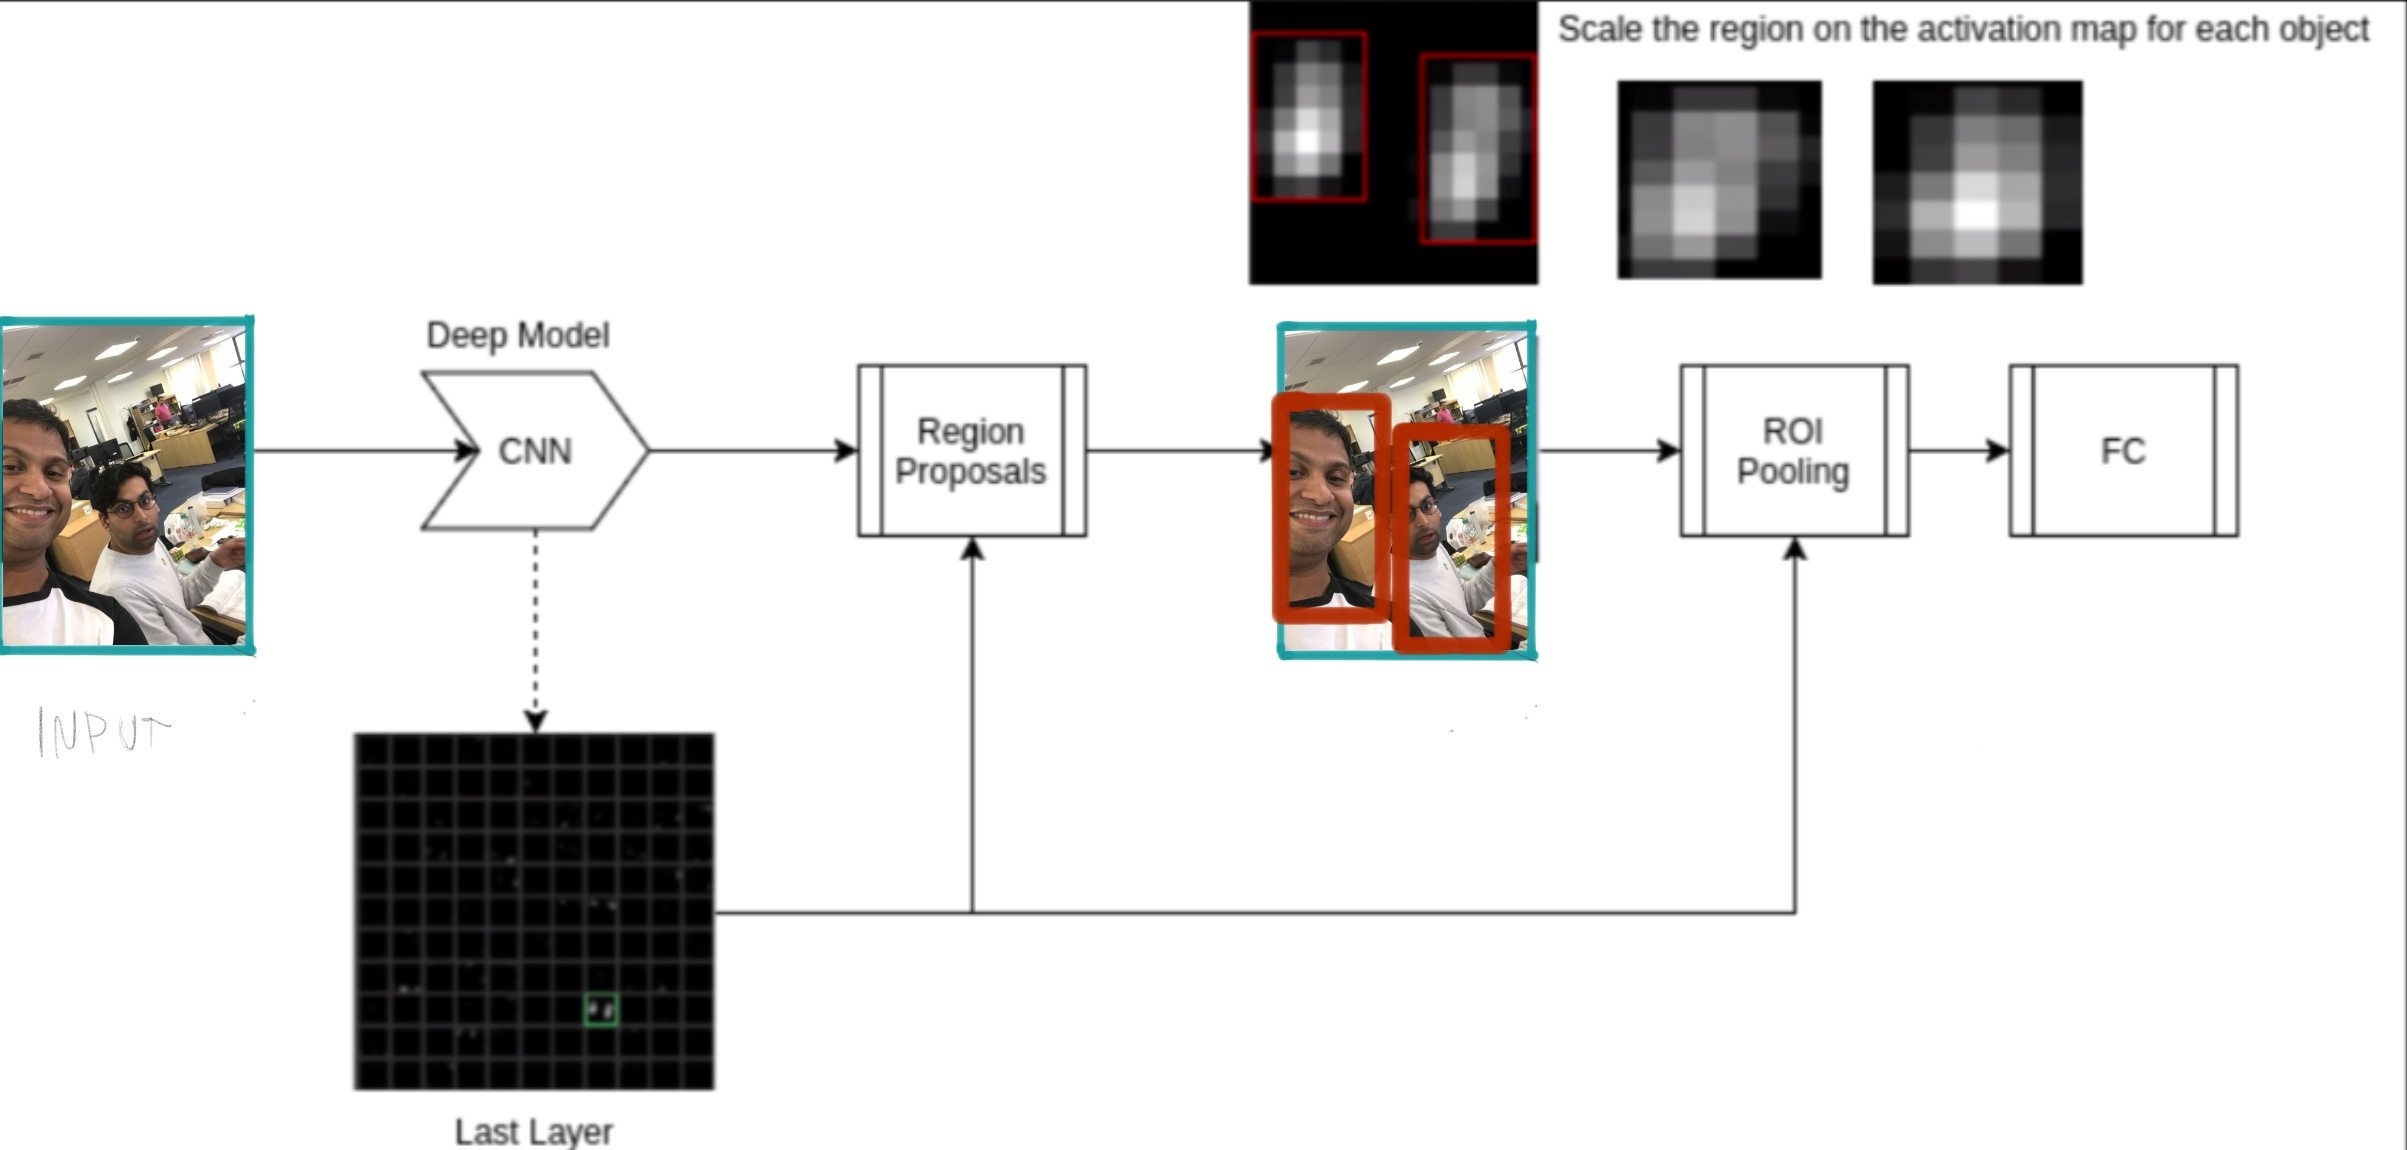

In [6]:
from IPython.display import Image
Image(filename='./images/fasterrcnn.jpg',height=400,width=400)

### Region Proposal Network

The job of the RPN is to predict whether something we call an anchor (essentially just a bounding box) contains an object or is only background, and then to refine the position of this bounding box.

Basically, the RPN does this by sliding a small window (3 x 3) across the last CNN feature map (the same feature map Fast R-CNN gets proposals from). For every sliding window center, we create k fixed anchor boxes and classify those boxes as containing an object or not:

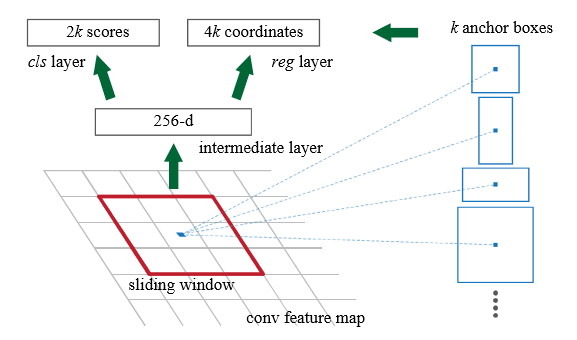

In [7]:
from IPython.display import Image
Image(filename='./images/rpn.png',height=400,width=400)

Internally, during training, we choose the anchor bounding box with the biggest IoU with the ground-truth bounding box for backpropagation.

### RoI Pooling layer